# 1. Import package

In [1]:
import os
os.chdir('..')

from pta_learn.ti_misc import *
from pta_learn.lmir import *
from pta_learn.tpmr import *
from pta_learn.ti_workflow import *
from pta_learn.superposition_calculation import *
from pta_learn.bourdet_derivative import *
from pta_learn.normalization import *

# 2. Import data

In [2]:
# data_path = 'F:/PhD/pta-learn/data'
data_path = './data'


# read ti_p and ti_r
df_bhp = pd.read_csv(data_path + '/ti_p.csv', index_col=0)
df_rate = pd.read_csv(data_path + '/ti_r.csv', index_col=0)

# change Timestamp to datetime
df_bhp['Timestamp'] = pd.to_datetime(df_bhp['Timestamp'])
df_rate['Timestamp'] = pd.to_datetime(df_rate['Timestamp'])

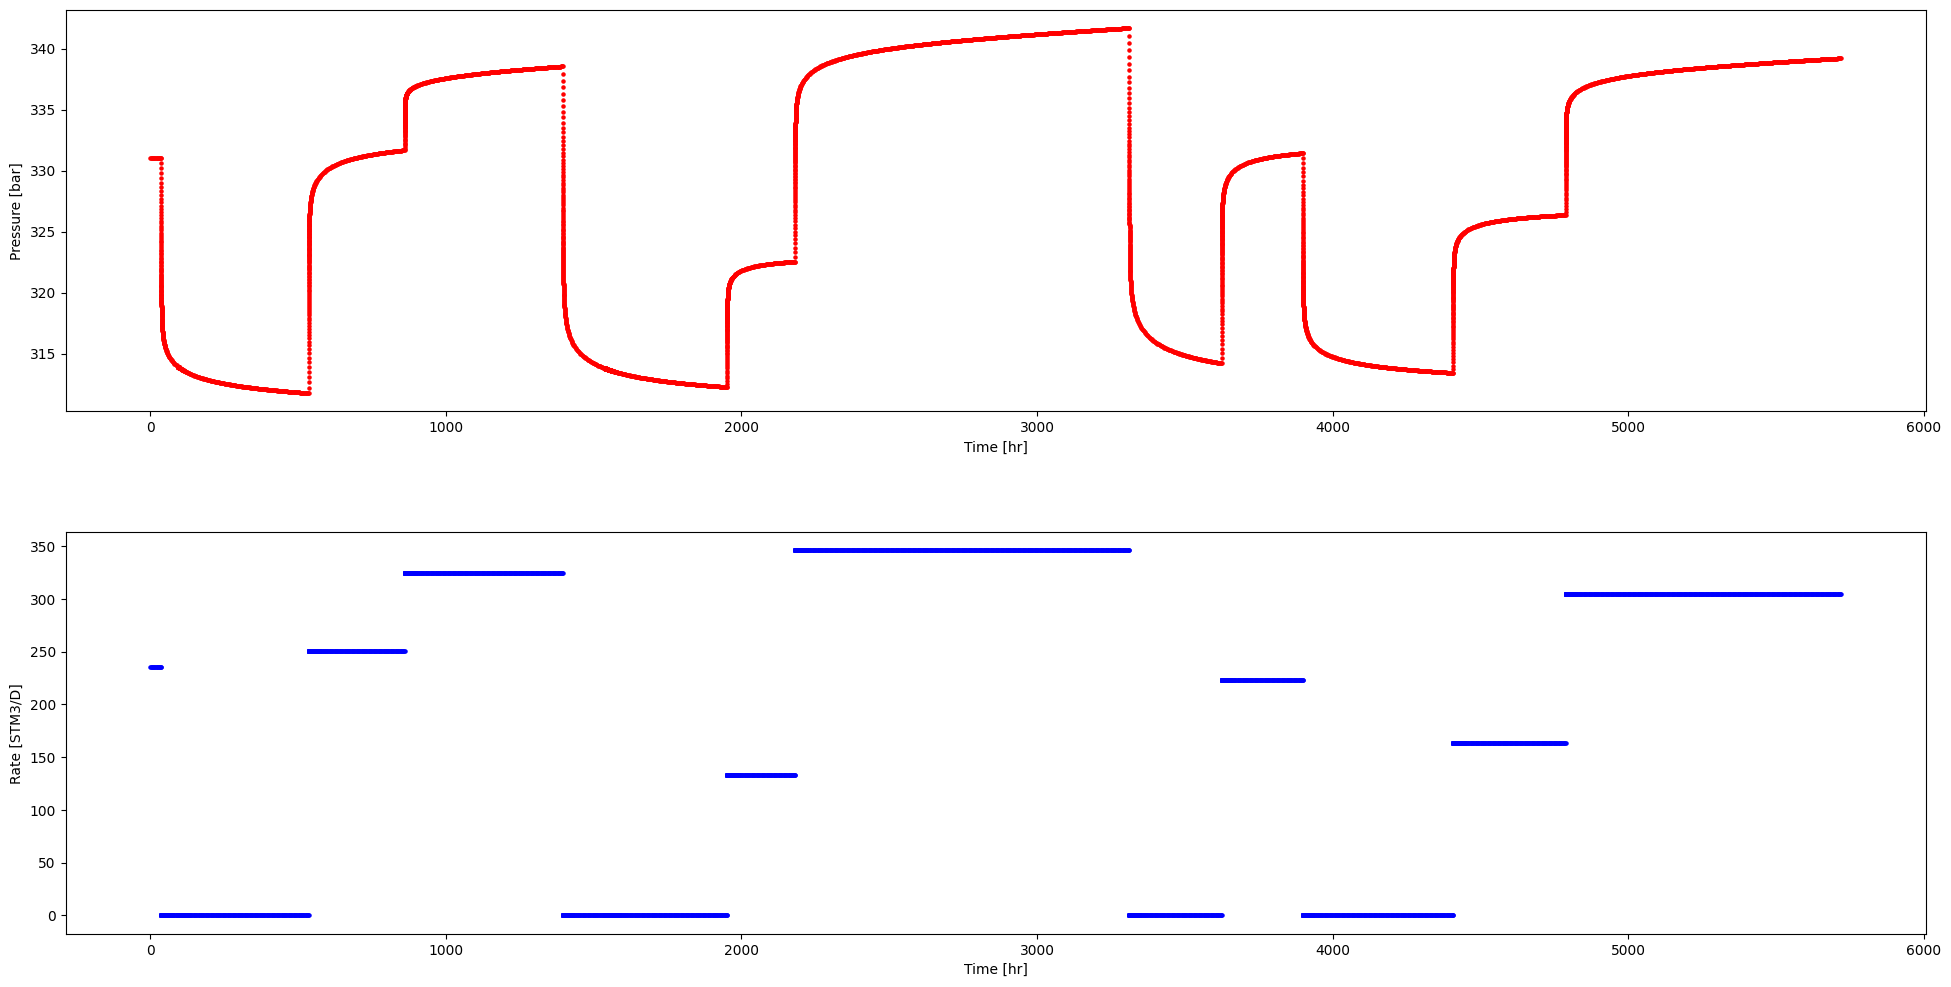

In [3]:
plot_whole(df_bhp,df_rate)

# 3. Transient Identification

## 3.1 set parameters

In [4]:
# p is the relative pressure drop in a shut-in transient
p = 10

# order is the number of points on both sides of the local minimas.
order = 100

# interval_shutin is the minimum time duration hours in a shut-in transient
interval_shutin = 20

# interval_flowing is the minimum time duration hours in a flowing transient
interval_flowing = 20

## 3.2 Transient identification calculation

In [5]:

shutin,flowing,TI,TI_ft,all_breakpoints,w_rate,para = ti_workflow(df_bhp, df_rate, p, interval_shutin, interval_flowing, order = order)

## 3.3 Plot the results

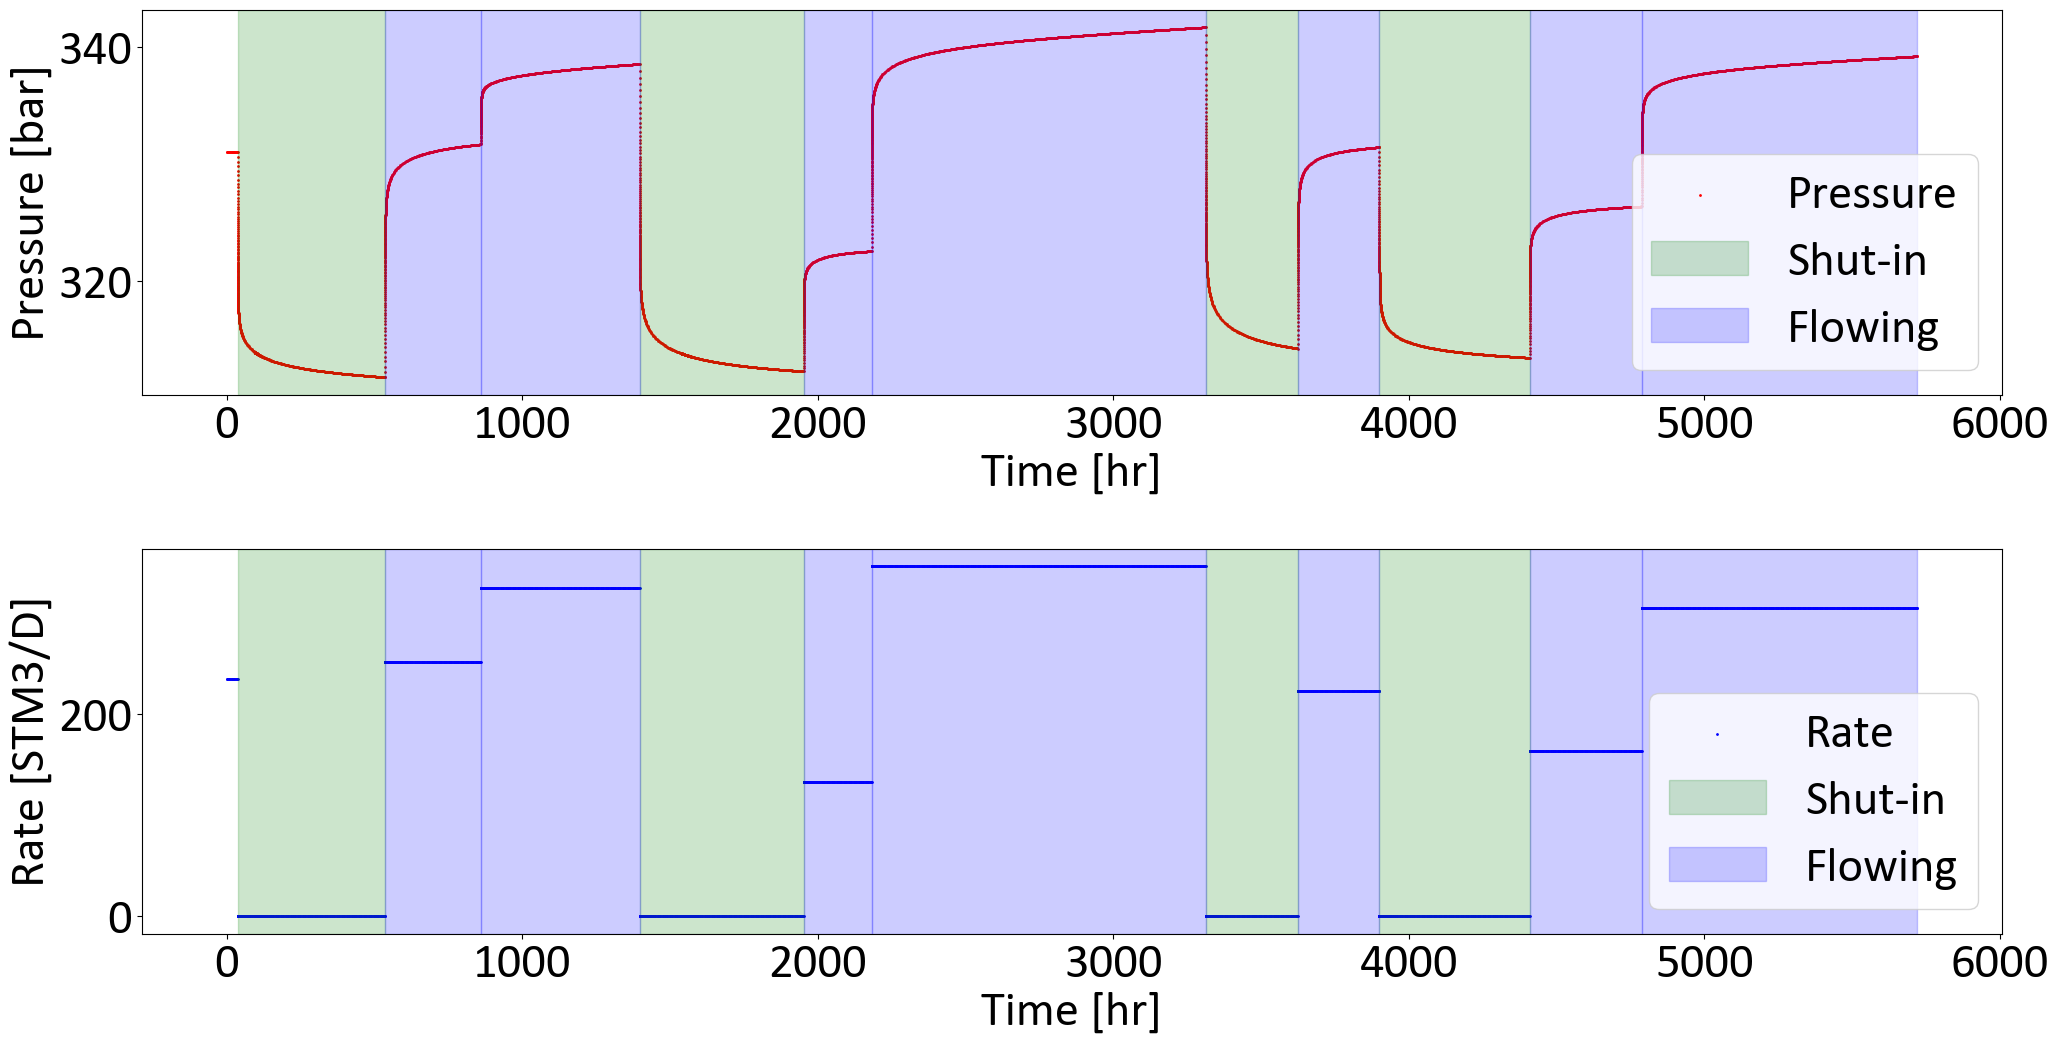

In [7]:
plot_target(df_bhp, df_rate, shutin, flowing)

# 4. Bourdet Derivative Calculation

## 4.1 Select transients for calculation

In [8]:
# make a list to store the loglog dataframe for any transients
loglogs = []
# make a list to store the rate list for any transients
rate_lists = []
# make a list to store the rate for any transients
rate_targets = []
# make a list to store the breakpoints for any transients
bps = []
# make a list to store the start time for any transients
historical_times = []

In [9]:
# Sel_shutin = shutin.loc[[0,1,2]].reset_index(drop=True)
# Sel_flowing = flowing.loc[[2,3]].reset_index(drop=True)

Sel_shutin = shutin
Sel_flowing = flowing
TI_empty = pd.DataFrame(columns=shutin.columns)

## 4.2 Bourdet Derivative Calculation

In [10]:
# smoothing factor for the derivative
L = 0.1

In [11]:
# calculate loglog dataframe for shut-in
for index in range(len(Sel_shutin)):

    # Call the cal_loglog_shutin function
    log, rate_ave, all_bps = cal_loglog_shut(df_bhp, df_rate, Sel_shutin, all_breakpoints,w_rate,index, L)
    # Append all outputs to respective lists as all are validated
    loglogs.append(log)
    rate_lists.append(rate_ave)
    rate_targets.append(abs(rate_ave[find_no0_index_from_bottom(rate_ave)]))
    bps.append(all_bps)
    historical_times.append(Sel_shutin['start/hr'][index])


# Calculate loglog dataframe for injection
for index in range(len(Sel_flowing)):
    # Call the cal_loglog_inj function
    log, rate_ave, all_bps = cal_loglog_inj(df_bhp, df_rate, Sel_flowing, all_breakpoints,w_rate,index,L)
    # Append all outputs to respective lists as all are validated
    loglogs.append(log)
    rate_lists.append(rate_ave)
    rate_targets.append(abs(rate_ave[find_no0_index_from_bottom(rate_ave)]))
    bps.append(all_bps)
    historical_times.append(Sel_flowing['start/hr'][index])

In [12]:
# sort the lists by historical time
sorted_lists = zip(loglogs, rate_lists, rate_targets, bps, historical_times)
sorted_lists = sorted(sorted_lists, key=lambda x: x[4])
loglogs, rate_lists, rate_targets, bps, historical_times = zip(*sorted_lists)

loglogs, rate_lists, rate_targets, bps, historical_times = [list(x) for x in [loglogs, rate_lists, rate_targets, bps, historical_times]]

## 4.3 Normalization Calculation

In [13]:
# set the reference transient for normalization
ref = 0

In [14]:
# normalize the derivative
loglog_normalized = []
for i in range(len(loglogs)):
    loglog_nor = normal_calc(loglogs[i],rate_lists[i],ref,rate_lists)
    loglog_normalized.append(loglog_nor)

## 4.4 Plot loglog family

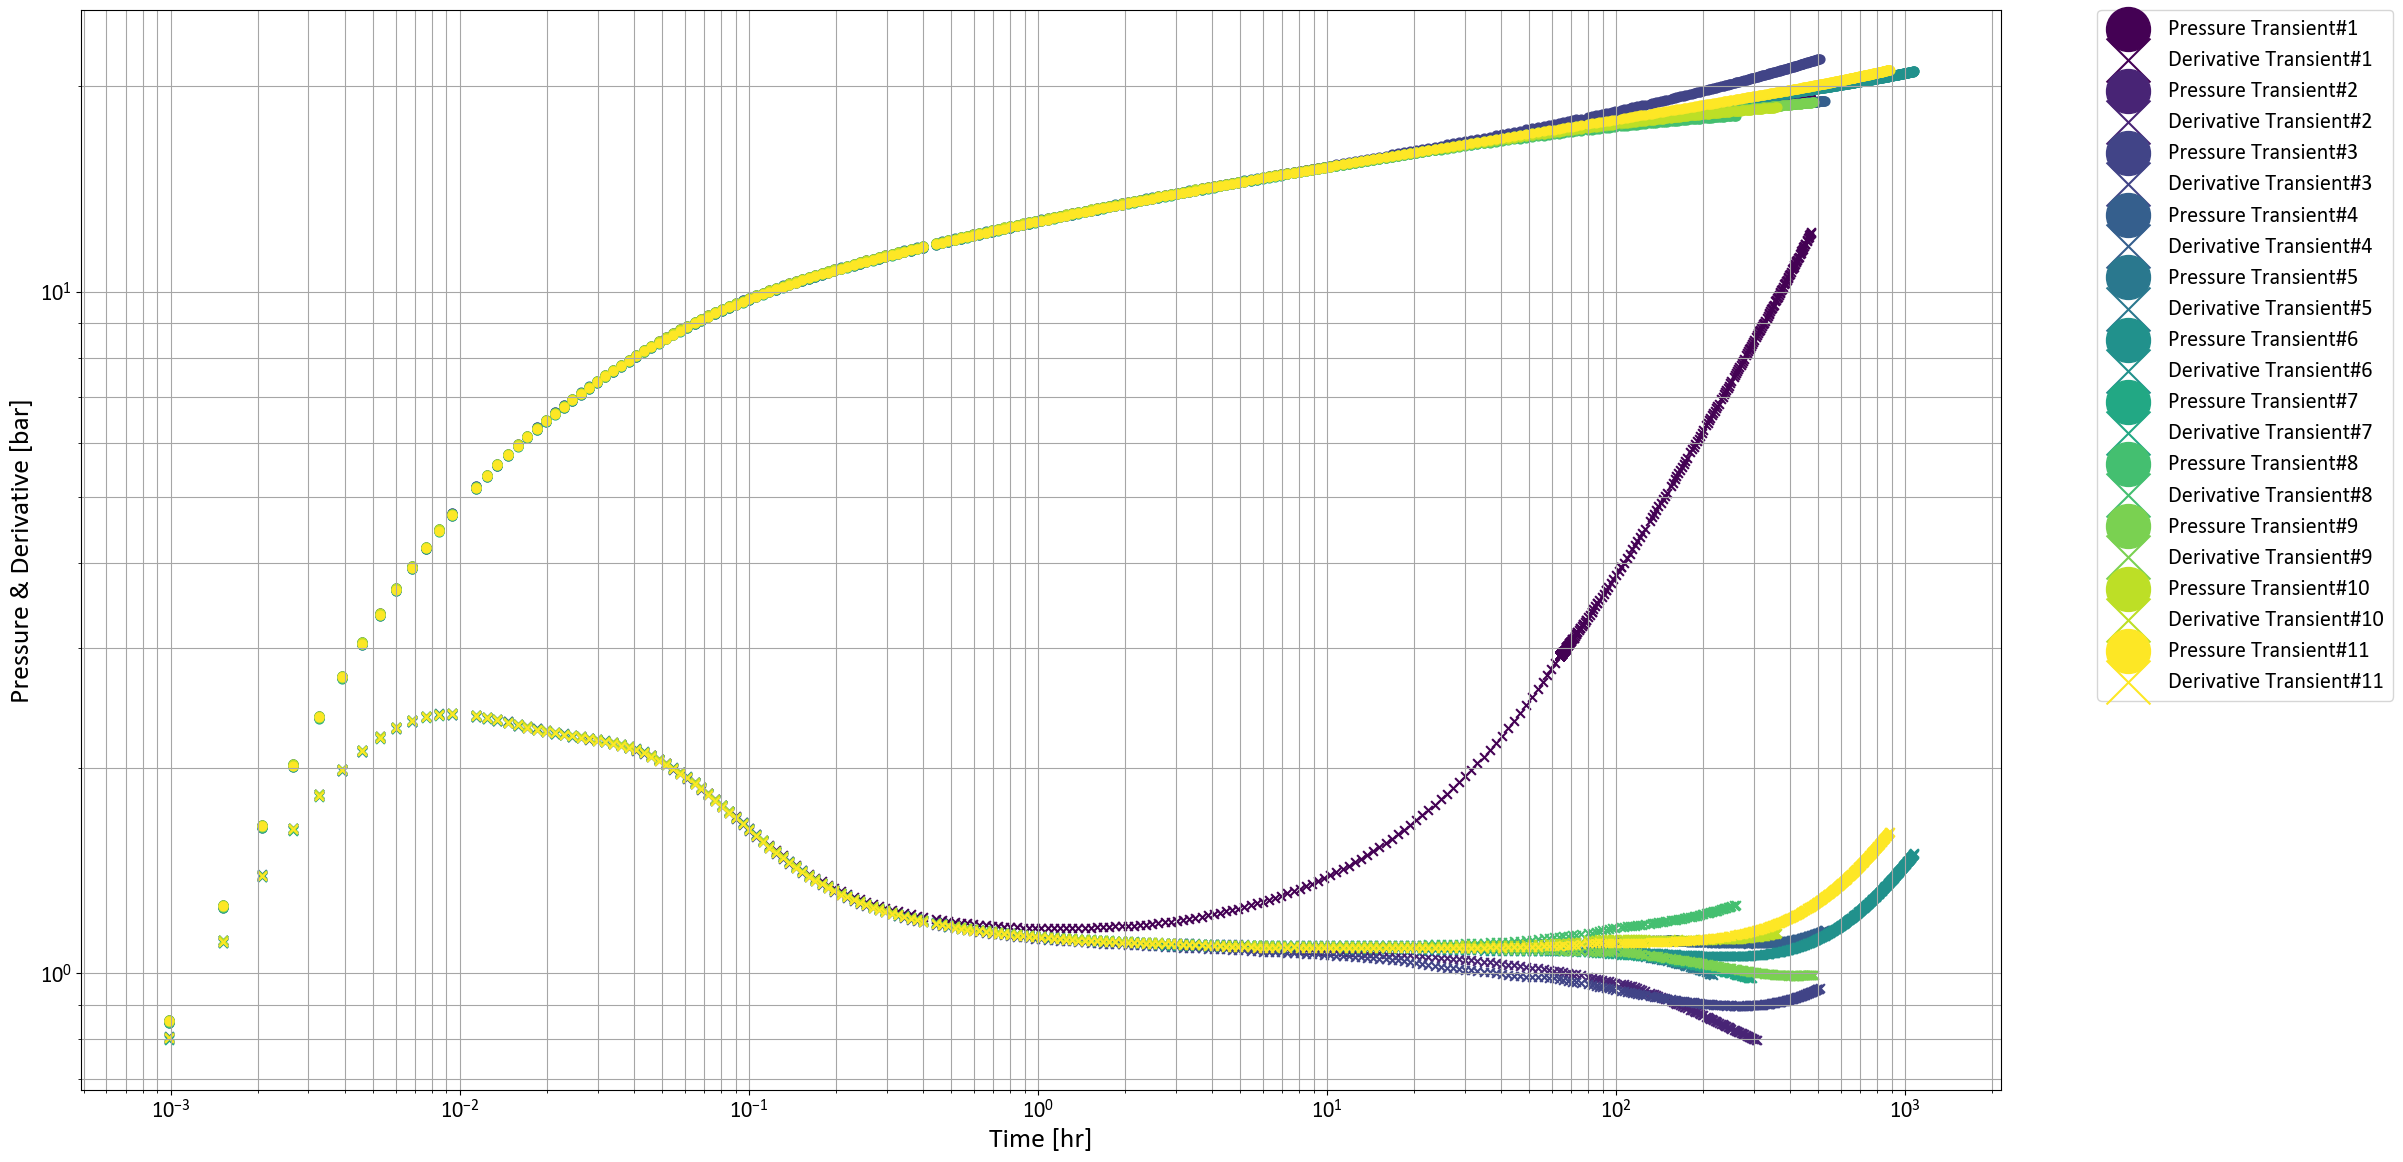

In [15]:
fig = plot_TI_family(*loglog_normalized)